# Reliability assessment Crown wall

In [46]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("default")

## Input parameters and their probabilistic distributions

In [47]:
N = 10000 #Number of Monte Carlo simulations
zeros = np.zeros(N)

# HEIGHTS i.r.t LAT

#Loads
SLR_mean = 0.0 # [m]
Hwaves_mean = 1.28 # [m]

#waterlevels
DWL_mean = 2 + SLR_mean # [m]
HAT_mean = 1 # [m]
MSL_mean = 0.53 # [m]
hcrest_mean = 4.1 # [m]

#other parameters
alpha_mean = 1/2 # [-]
Tm1_mean = 3.7 # [s]
gammab_mean = 1 # [-]
gammaf_mean = 0.55 # [-]
gammaBeta_mean = 1 # [-]
#gammav_mean = 1 # [m]
hwall_mean = 0.5 # [-]
g_mean = 9.81 # [m/s^2]

#resistance limit state functions
overtopping_R = 5 # [l/s/m]

#Overtopping
g = scipy.stats.norm(g_mean, 0.0).rvs(N)
DWL = scipy.stats.norm(DWL_mean, 0.05*DWL_mean).rvs(N)
HAT = scipy.stats.norm(HAT_mean, 0.05*HAT_mean).rvs(N)
hcrest = scipy.stats.norm(hcrest_mean, 0.05*hcrest_mean).rvs(N)
alpha = scipy.stats.norm(alpha_mean, 0.05*alpha_mean).rvs(N)
Tm1 = scipy.stats.norm(Tm1_mean, 0.05*Tm1_mean).rvs(N)
gammab = scipy.stats.norm(gammab_mean, 0.0*gammab_mean).rvs(N)
gammaf = scipy.stats.norm(gammaf_mean, 0.0*gammaf_mean).rvs(N)
gammaBeta = scipy.stats.norm(gammaBeta_mean, 0.0*gammaBeta_mean).rvs(N)
#gammav = scipy.stats.norm(gammav_mean, 0.0*gammav_mean).rvs(N)
overtopping = scipy.stats.norm(overtopping_R,0.05*overtopping_R).rvs(N)
hwall = scipy.stats.norm(hwall_mean, 0.05*hwall_mean).rvs(N)

## Limit State Function

In [48]:
def Overflow( SLR_mean , Hwaves_mean , hcrest, DWL, hwall ):
    SLR = scipy.stats.norm(SLR_mean, 0.05*SLR_mean).rvs(N)
    Hwaves = scipy.stats.norm(Hwaves_mean, 0.05*Hwaves_mean).rvs(N)
    
    R_overflow = hcrest + hwall
    S_overflow = DWL + SLR +0.2*Hwaves
    LS_overflow = R_overflow - S_overflow
    return LS_overflow


def Overtopping(overtopping,g,hcrest, Tm1, alpha, gammab, SLR_mean, Hwaves_mean, gammaf, gammaBeta, hwall):
    SLR = scipy.stats.norm(SLR_mean, 0.05*SLR_mean).rvs(N)
    Hwaves = scipy.stats.norm(Hwaves_mean, 0.05*Hwaves_mean).rvs(N)
    Rc = hcrest + hwall - DWL - SLR + hwall
    Lm1 = (g*Tm1**2) / (2*np.pi)
    Irri = (alpha)/((Hwaves/Lm1)**0.5)
    gammav = np.exp(-0.56*(hwall/Rc))
    if np.nanmean(gammav)  > 1:
        gammav = 0.5
    
    if any(Rc) > 0.0 and all(Irri) < 7:
        S_overtopping = (((g*Hwaves**3)**0.5)*(0.023/((alpha)**0.5))*gammab*Irri*np.exp(-(2.7*np.abs(Rc/(Irri*Hwaves*gammab*gammaf*gammaBeta*gammav))))**1.3)*1000
        S_overtopping_max = (((g*Hwaves**3)**0.5)*0.09*np.exp(-(1.5*abs(Rc)/(Hwaves*gammaf*gammaBeta*gammav))**1.3))*1000
        if np.nanmean(S_overtopping) >= np.nanmean(S_overtopping_max):
            S_overtopping = S_overtopping_max
    elif any(Rc) > 0.0 and all(Irri) > 7:
        S_overtopping = (((g*Hwaves**3)**0.5)*(1/(10**0.79))*np.exp(-Rc/((Hwaves*gammab*gammaf)*(0.33+0.022*Irri)))**1.3)*1000
    else:
        S_overtopping = overtopping+1
    S_overtopping = np.array(S_overtopping)
    count_nan = N - np.count_nonzero(~np.isnan(S_overtopping))
    
    if count_nan > 0.001*N: #to ensure all numbers are real
        S_overtopping = overtopping+1
    R_overtopping = overtopping
    LS_overtopping = R_overtopping - S_overtopping 
    return LS_overtopping


N_overtopping = np.less_equal(Overtopping(overtopping,g,hcrest, Tm1, alpha, gammab, SLR_mean, Hwaves_mean, gammaf, gammaBeta, hwall), zeros)
N_overflow = np.less_equal(Overflow( SLR_mean , Hwaves_mean , hcrest, DWL, hwall ), zeros)
failure_overtopping = np.sum(N_overtopping) / float(N)
failure_overflow = np.sum(N_overflow) / float(N)


## Results different heights crown wall

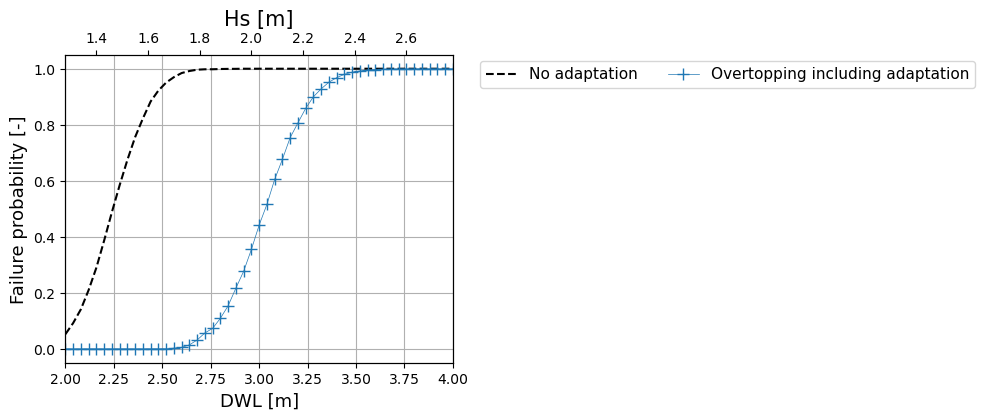

In [49]:
list_overtopping = [] # empty list for conditional failure probabilities
list_overflow = [] # empty list for conditional failure probabilities


N_vertical = 50 #Number of points on horizontal axis

#Min and max values for the different loads
SLR_max = 2 
SLR_min = 0

Hwaves_max = 3 # offshore wave heigth
Hwaves_min = 0.5

SLR_range =np.arange(SLR_min,1.001*SLR_max ,(SLR_max-SLR_min)/N_vertical)
Hwaves_range = np.arange(Hwaves_min,1.001*Hwaves_max,(Hwaves_max-Hwaves_min)/N_vertical)
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(111)


#Choose type of hydraulic loading which will gradually increase
# 1 = rising water levels (sea level rise)
# 2 = rising wave height
# 3 = combination of both when incoming waves are depth-limited

x = 3

if x == 1:
    a = SLR_range
    c = scipy.stats.norm(Hwaves_mean, 0.0).rvs(N)
    d = a + DWL_mean
    ax1.set_xlim(DWL_mean, SLR_max + DWL_mean)
    title = 'Pf vs DWL' 
    xas = 'DWL [m]'
    yas = 'Failure probability [-]'
elif x == 2:
    a = scipy.stats.norm(SLR_mean, 0.0).rvs(N)
    c = Hwaves_range
    d = c 
    ax1.set_xlim(Hwaves_min,  Hwaves_max)
    title = 'Pf vs Hs'
    xas = 'Hs [m]'
    yas = 'Failure probability [-]'
elif x == 3:
    DWL = scipy.stats.norm(DWL_mean, 0.0*DWL_mean).rvs(N)
    a = SLR_range 
    c =  (Hwaves_mean + 0.75*SLR_range)
    d = a + DWL_mean
    title = ''
    xas = 'DWL [m]'
    yas = 'Failure probability [-]'
    ax2 = ax1.twiny()
    ax1.set_xlim(DWL_mean, SLR_max + DWL_mean)
    ax2.set_xlim(Hwaves_mean, (Hwaves_mean + 0.75*SLR_max))
    ax2.set_xlabel('Hs [m]', size = 15)



for i in range(len(d)):
    SLR_mean = a[i]
    Hwaves_mean = c[i]
    failure_overtopping = np.sum(np.less_equal(Overtopping(overtopping,g,hcrest, Tm1, alpha, gammab, SLR_mean, Hwaves_mean, gammaf, gammaBeta, hwall), zeros)) / float(N)
    failure_overflow = np.sum(np.less_equal(Overflow( SLR_mean , Hwaves_mean , hcrest, DWL, hwall ), zeros)) / float(N)

    list_overtopping.append(failure_overtopping)
    list_overflow.append(failure_overflow)

#conditional failure probabilities extracted from the revetment file 'Reliability_revetment_Merak'
old_total =[0.46189853862999997, 0.54032353948, 0.6201321609999999, 0.698753334124, 0.77223108331, 0.838445271985, 0.886039966384, 0.925695909055, 0.9532469377, 0.971727964, 0.984720519664, 0.991938206596, 0.996190785038, 0.99816799112, 0.999136149264, 0.9996918922, 0.999884865358, 0.99996263701, 0.99998497292, 0.999991157552, 0.9999966775, 0.999998365528, 0.9999993879652096, 1.0, 0.9999999216362015, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
old_overflow =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0005, 0.0007, 0.0019, 0.0025, 0.0051, 0.0091, 0.0153, 0.0237, 0.043, 0.0712, 0.1006, 0.1426, 0.2007, 0.2546, 0.3328, 0.4172, 0.4937, 0.5719, 0.6482, 0.7209, 0.7782, 0.8351, 0.8782, 0.9167, 0.9421, 0.9611, 0.977]
old_toearmour=[0.0115, 0.0154, 0.0225, 0.0302, 0.0395, 0.0531, 0.0628, 0.0767, 0.0955, 0.1087, 0.1301, 0.1507, 0.1698, 0.1938, 0.2072, 0.2305, 0.2571, 0.2738, 0.2978, 0.3156, 0.3355, 0.3514, 0.3624, 0.3807, 0.3969, 0.4112, 0.4248, 0.4385, 0.4463, 0.457, 0.466, 0.4763, 0.4836, 0.4982, 0.5024, 0.5103, 0.5172, 0.5289, 0.5342, 0.539, 0.5436, 0.5468, 0.5541, 0.5635, 0.5685, 0.5706, 0.5751, 0.5795, 0.5856, 0.587, 0.5933]
old_erosion =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
old_Meer =[0.4259, 0.486, 0.5476, 0.6069, 0.6661, 0.7219, 0.7626, 0.8065, 0.8412, 0.87, 0.9011, 0.9188, 0.9411, 0.954, 0.9638, 0.974, 0.9811, 0.9853, 0.9893, 0.9932, 0.995, 0.9958, 0.9976, 0.9981, 0.9987, 0.9994, 0.9996, 0.9997, 0.9999, 0.9999, 1.0, 1.0, 0.9999, 0.9999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
old_overtopping =[0.0518, 0.0917, 0.141, 0.2098, 0.2898, 0.3865, 0.4878, 0.5841, 0.6745, 0.756, 0.8224, 0.8831, 0.9221, 0.9506, 0.9699, 0.9846, 0.9918, 0.9965, 0.998, 0.9981, 0.999, 0.9994, 0.9996, 1.0, 0.9999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


#trialing three different heights (1.0 , 0.75 and 0.50 m)
wall10 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0009, 0.0018, 0.0033, 0.0064, 0.0104, 0.0188, 0.0321, 0.051, 0.0736, 0.1061, 0.1438, 0.1996, 0.2621, 0.3346, 0.4049, 0.4827, 0.5602, 0.6326, 0.7012, 0.7612, 0.8185, 0.8651, 0.9016, 0.9285, 0.9511, 0.9672, 0.9775, 0.9854, 0.9912, 0.9941, 0.9959, 0.9975, 0.9988, 0.9993, 0.9994]
wall05 = [0.0, 0.0, 0.0002, 0.0001, 0.0006, 0.0009, 0.0015, 0.0046, 0.0092, 0.0163, 0.0287, 0.046, 0.0756, 0.1211, 0.1707, 0.2362, 0.3161, 0.3997, 0.4884, 0.5774, 0.6651, 0.7386, 0.8074, 0.858, 0.9066, 0.9355, 0.9603, 0.9743, 0.9855, 0.9923, 0.9958, 0.9967, 0.999, 0.9992, 0.9997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9997, 0.9997, 0.9929, 0.9952, 0.9977, 0.9986, 0.9997, 0.9997]
wall75 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0001, 0.0003, 0.0004, 0.0009, 0.0033, 0.0053, 0.0078, 0.0158, 0.028, 0.0483, 0.0778, 0.1092, 0.1614, 0.2233, 0.2907, 0.3723, 0.4565, 0.5364, 0.6166, 0.6913, 0.7629, 0.8202, 0.8676, 0.9038, 0.9313, 0.9522, 0.971, 0.9799, 0.9878, 0.9924, 0.9961, 0.9975, 0.9984, 0.9991, 0.9998, 0.9997, 0.9997, 0.9999, 1.0, 0.9996, 0.9997, 0.9996, 0.9993]

ax1.plot(d,old_overtopping, label = 'No adaptation', linestyle = '--', color = 'black')
ax1.plot(d,list_overtopping, label = 'Overtopping including adaptation', linewidth = 0.5, marker ='+', markersize = '8')



ax1.set_title(title, size = 13)
ax1.grid()
ax1.set_ylabel(yas, size = 13)
ax1.set_xlabel(xas, size=13)
ax1.legend(bbox_to_anchor=(1.05, 1.005), loc='upper left', ncol = 2,  prop={"size":11})
plt.show()

#print(list_overtopping)

## Impact crown wall combined failure probability

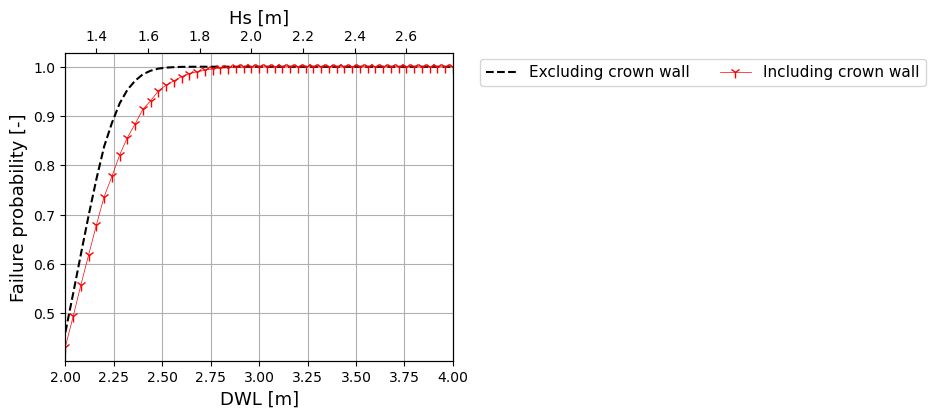

In [36]:
list_new = []

#Combining old failure probabilities for unaffected limit state functions with the newly computed ones for the affected ones
for i in range(N_vertical+1):
    Pf_layer1 = 1-((1-old_toearmour[i])*(1-old_Meer[i])) #Failure tree armour breakage (OR gates)
    Pf_independent = 1-((1-list_overflow[i])*(1-list_overtopping[i])*(1-Pf_layer1)*(1-old_erosion[i])) #Failure top event (failure revetments)
    list_new.append(Pf_independent)

#reiterate wave height to ensure correct increase of legend 
Hwaves_mean = 1.28

fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_xlim(DWL_mean, SLR_max + DWL_mean)
ax2.set_xlim(Hwaves_mean, (Hwaves_mean + 0.75*SLR_max))
ax2.set_xlabel('Hs [m]', size = 13)
ax1.plot(d,old_total, label = 'Excluding crown wall', linestyle = '--', color = 'black')
ax1.plot(d,list_new, label = 'Including crown wall', color = 'red', linewidth = 0.5, marker ='1', markersize = '8')
ax1.set_title(title, size = 13)
ax1.grid()
ax1.set_ylabel(yas, size = 13)
ax1.set_xlabel(xas, size=13)
ax1.legend(bbox_to_anchor=(1.05, 1.005), loc='upper left', ncol = 2,  prop={"size":11})
plt.show()
